This notebook is aiming to gain insight into student performance in 8 fully asynchronous intoduction to programming in java courses that were taught by Professor Arnow between 2019 and 2024. The dataset was isolated and cleaned from a larger SQL database and data from Spring 2019, Spring/Fall 2020, Spring/Fall 2021, Spring/Fall 2023, and Spring 2024 are used in this analysis.

Let's first import the dataset and find the average # of submissions per exercise by students in each course.

In [3]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
file_path = '~/cisc5001/Submission_Data_Raw.csv' 
data = pd.read_csv(file_path)

# Aim 1: Count the number of unique students in each section
students_per_course = data.groupby('Sem')['user_id'].nunique().reset_index(name='num_students')

# Aim 2: Calculate the total number of submissions per section
submissions_per_course = data.groupby('Sem')['submission_id'].count().reset_index(name='total_submissions')

# Aim 3: Merge the two results and calculate the average submissions per student per course
course_stats = pd.merge(students_per_course, submissions_per_course, on='Sem')
course_stats['avg_submissions_per_student'] = course_stats['total_submissions'] / course_stats['num_students']

# Cleanup 1: Parse the 'Sem' column to order chronologically
course_stats['Year'] = course_stats['Sem'].str.extract(r'(\d{4})').astype(int)
course_stats['Semester'] = course_stats['Sem'].str.contains("Spring").map({True: 0, False: 1})  # Spring = 0, Fall = 1

# Cleanup 2: Sort by year and semester
course_stats = course_stats.sort_values(['Year', 'Semester']).drop(columns=['Year', 'Semester']).reset_index(drop=True)

display(course_stats)

,Sem,num_students,total_submissions,avg_submissions_per_student
0,Spring 2019,61,32469,532.278689
1,Spring 2020,61,31773,520.868852
2,Fall 2020,63,68265,1083.571429
3,Spring 2021,56,55796,996.357143
4,Fall 2021,79,66077,836.417722
5,Spring 2023,81,104116,1285.382716
6,Fall 2023,70,72498,1035.685714
7,Spring 2024,73,46336,634.739726


Seems that there is quite a bit of variation in the number of submissions per semester! In Spring 2023, the average total # of submissions per student was ~1285 whereas just four years ago in Spring 2019 the average submissions per student was ~532.

I wonder if the course has been changed at all in terms of the amount of exercises between spring 2019 and spring 2023. Let's investigate further!

In [32]:
# Aim 4: Count the total number of unique exercises in each course
# Group by 'Sem' and count unique 'exercise_ssn' values for distinct exercises in each semester
exercises_per_course = data.groupby('Sem')['exercise_ssn'].nunique().reset_index(name='num_exercises')

# Merge exercise counts with course_stats to see submissions and exercises together
course_stats = pd.merge(course_stats, exercises_per_course, on='Sem')

# Display the final DataFrame with all calculated metrics
display(course_stats)

,Sem,num_students,total_submissions,avg_submissions_per_student,num_exercises
0,Spring 2019,61,32469,532.278689,632
1,Spring 2020,61,31773,520.868852,550
2,Fall 2020,63,68265,1083.571429,802
3,Spring 2021,56,55796,996.357143,832
4,Fall 2021,79,66077,836.417722,942
5,Spring 2023,81,104116,1285.382716,1007
6,Fall 2023,70,72498,1035.685714,1068
7,Spring 2024,73,46336,634.739726,1091


Wow! It seems that the number of exercises has generally only increased throughout the years. We should standardize our previous findings to account for the fact that there is a different # of exercises in each course. To do so, let's find the average # of submissions per exercise and then find the average # of submissions per exercise per student.

In [33]:
# Add new columns for average # of submissions per exercise and average # of submissions per exercise per student
course_stats['avg_submissions_per_exercise'] = course_stats['total_submissions'] / course_stats['num_exercises']
course_stats['avg_submissions_per_exercise_per_student'] = course_stats['avg_submissions_per_exercise'] / course_stats['num_students']

# Display the final DataFrame with all calculated metrics
display(course_stats)

,Sem,num_students,total_submissions,avg_submissions_per_student,num_exercises,avg_submissions_per_exercise,avg_submissions_per_exercise_per_student
0,Spring 2019,61,32469,532.278689,632,51.375000,0.842213
1,Spring 2020,61,31773,520.868852,550,57.769091,0.947034
2,Fall 2020,63,68265,1083.571429,802,85.118454,1.351087
3,Spring 2021,56,55796,996.357143,832,67.062500,1.197545
4,Fall 2021,79,66077,836.417722,942,70.145435,0.887917
5,Spring 2023,81,104116,1285.382716,1007,103.392254,1.276448
6,Fall 2023,70,72498,1035.685714,1068,67.882022,0.969743
7,Spring 2024,73,46336,634.739726,1091,42.471127,0.581796


Wow, it seems that Fall 2020 had the highest amount of average submissions per exercise per student at ~1.35 whereas Spring 2024 had the least at ~0.58. I wonder if drop rates can explain this. It would make sense that DWFI (drop, withdraw, fail, incomplete) rates may explain this, and spring 2024 may have a higher DWFI than something like Fall 2020 where there was greater participation in the course. A broader investigation of this must be done. A KEY downstream analysis that can be done later is to identify specific DWFI students and look at the data with JUST those students and without those students. 

What we CAN do NOW though is parse out students who didn't really engage in the course. The average number of submissions per student is in the higher hundreds. However, there are many students who may have simply signed up for the course, did a few exercises, and dropped the course soon thereafter. There is no great way to create a definitive threshold of how many submissions a student has to have to be considered for analysis, however, let's create a visual distribution of the # of submissions per student in general to see where the data spikes. 

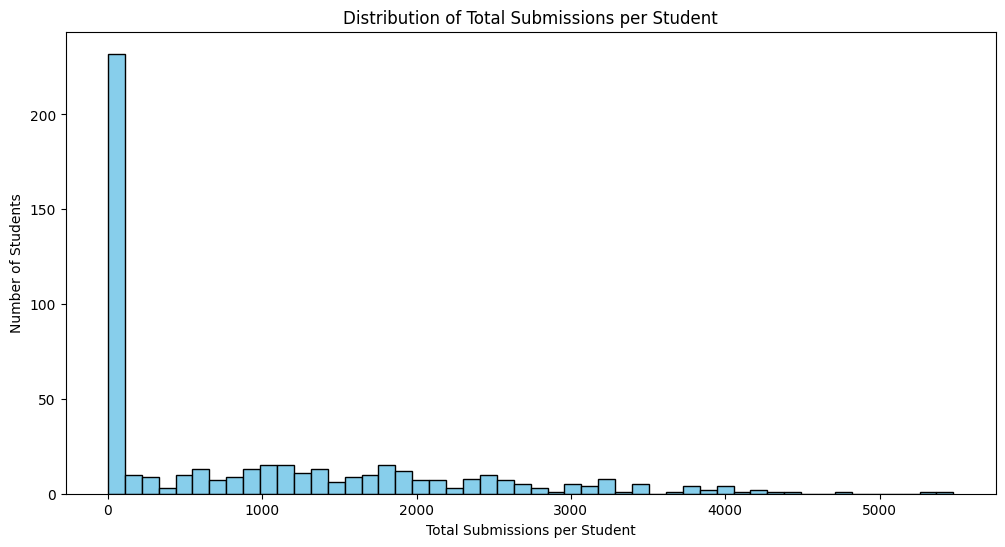

In [34]:
import matplotlib.pyplot as plt

# Calculate the total number of submissions per student
submissions_per_student = data.groupby('user_id')['submission_id'].count().reset_index(name='total_submissions')

# Plot the distribution of total submissions per student
plt.figure(figsize=(12, 6))
plt.hist(submissions_per_student['total_submissions'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Submissions per Student')
plt.xlabel('Total Submissions per Student')
plt.ylabel('Number of Students')
plt.show()

Wow! It seems that there are TONS of students who have under 100 submissions that are pulling the data down! These students are very likely students that dropped the course VERY soon after enrolling in the course. Let's redo the above analyses with all students who had under 100 submissions parsed out! A key downstream analysis could be to obtain DWFI information and associate them with specific students for more accurate information.

In [35]:
# Calculate total submissions per student
submissions_per_student = data.groupby('user_id')['submission_id'].count().reset_index(name='total_submissions')

# Identify students with 100 or more submissions and filter dataset
engaged_students = submissions_per_student[submissions_per_student['total_submissions'] >= 100]['user_id']
data_cleaned = data[data['user_id'].isin(engaged_students)]

# Count the number of unique students in each section for engaged students
students_per_course_cleaned = data_cleaned.groupby('Sem')['user_id'].nunique().reset_index(name='num_students')

# Calculate the total number of submissions per section for engaged students
submissions_per_course_cleaned = data_cleaned.groupby('Sem')['submission_id'].count().reset_index(name='total_submissions')

# Merge results and calculate average submissions per student per course for engaged students
course_stats_cleaned1 = pd.merge(students_per_course_cleaned, submissions_per_course_cleaned, on='Sem')
course_stats_cleaned1['avg_submissions_per_student'] = course_stats_cleaned1['total_submissions'] / course_stats_cleaned1['num_students']

# Parse the 'Sem' column to order chronologically
course_stats_cleaned1['Year'] = course_stats_cleaned1['Sem'].str.extract(r'(\d{4})').astype(int)
course_stats_cleaned1['Semester'] = course_stats_cleaned1['Sem'].str.contains("Spring").map({True: 0, False: 1})  # Spring = 0, Fall = 1

# Sort by year and semester
course_stats_cleaned1 = course_stats_cleaned1.sort_values(['Year', 'Semester']).drop(columns=['Year', 'Semester']).reset_index(drop=True)

# Count the total number of unique exercises in each course for engaged students
exercises_per_course_cleaned = data_cleaned.groupby('Sem')['exercise_ssn'].nunique().reset_index(name='num_exercises')

# Merge exercise counts with course_stats_cleaned1 to see submissions and exercises together
course_stats_cleaned1 = pd.merge(course_stats_cleaned1, exercises_per_course_cleaned, on='Sem')

# Add new columns for average # of submissions per exercise and per exercise per student
course_stats_cleaned1['avg_submissions_per_exercise'] = course_stats_cleaned1['total_submissions'] / course_stats_cleaned1['num_exercises']
course_stats_cleaned1['avg_submissions_per_exercise_per_student'] = course_stats_cleaned1['avg_submissions_per_exercise'] / course_stats_cleaned1['num_students']

# Display the final DataFrame
display(course_stats_cleaned1)

,Sem,num_students,total_submissions,avg_submissions_per_student,num_exercises,avg_submissions_per_exercise,avg_submissions_per_exercise_per_student
0,Spring 2019,35,32083,916.657143,632,50.764241,1.450407
1,Spring 2020,37,31411,848.945946,550,57.110909,1.543538
2,Fall 2020,38,67847,1785.447368,802,84.597257,2.226244
3,Spring 2021,36,55388,1538.555556,832,66.572115,1.849225
4,Fall 2021,39,65277,1673.769231,942,69.296178,1.776825
5,Spring 2023,48,103412,2154.416667,1007,102.693148,2.139441
6,Fall 2023,40,71899,1797.475000,1068,67.321161,1.683029
7,Spring 2024,36,45536,1264.888889,1091,41.737855,1.159385


Let's now create a new distribution of total submissions per student with this parsed out data before we look deeper!

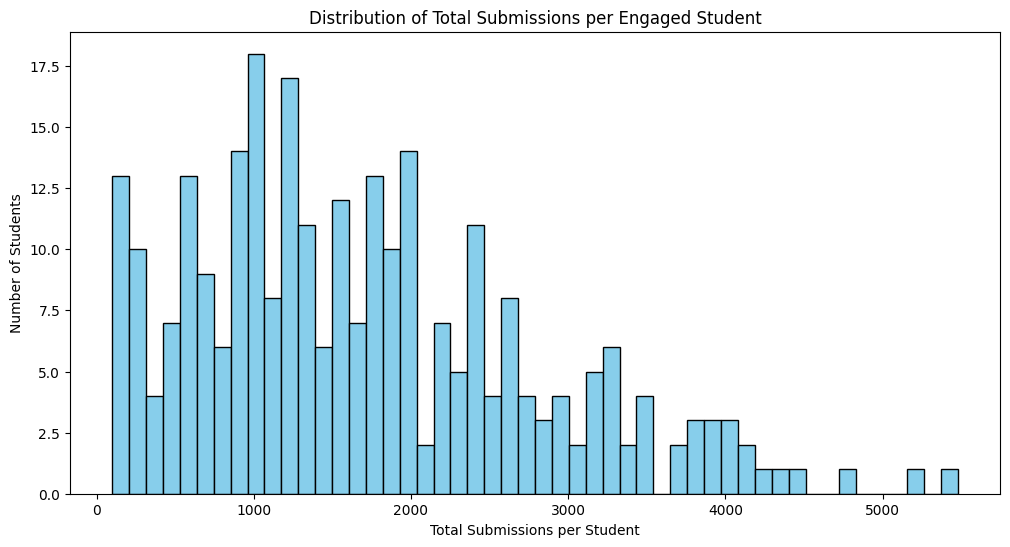

In [36]:
data_cleaned = data[data['user_id'].isin(engaged_students)]

# Calculate the total number of submissions per "engaged" student
submissions_per_engaged_student = data_cleaned.groupby('user_id')['submission_id'].count().reset_index(name='total_submissions')

# Plot
plt.figure(figsize=(12, 6))
plt.hist(submissions_per_engaged_student['total_submissions'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Submissions per Engaged Student')
plt.xlabel('Total Submissions per Student')
plt.ylabel('Number of Students')
plt.show()

Much better! Looking at students who engaged with the course for more than just a few exercises, Fall 2020 seems to still have the highest number of submissions per exercise per student with ~2.23 while Spring 2024 is the lowest at ~1.16. For good measure, let's run some stats on this new dataset to find if there is a significantly different # of submissions per exercise per student in all of the semesters. We will run a simple ANOVA. 

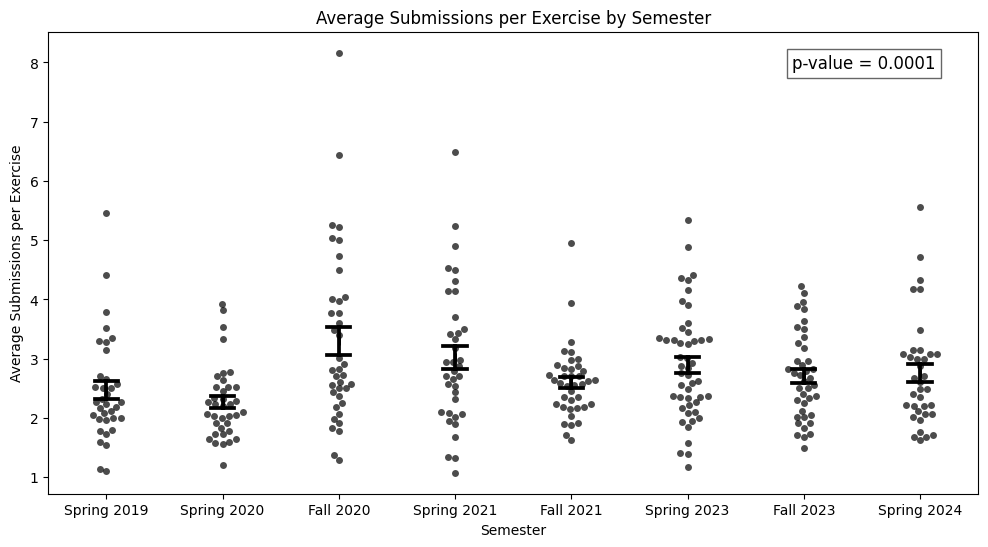

In [37]:
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the average number of submissions per exercise for each student in each semester
student_avg_submissions = data_cleaned.groupby(['user_id', 'Sem'], as_index=False).apply(
    lambda x: pd.Series({'avg_submissions_per_exercise': x['submission_id'].count() / x['exercise_ssn'].nunique()}))

# Extract year and semester to sort chronologically
student_avg_submissions['Year'] = student_avg_submissions['Sem'].str.extract(r'(\d{4})').astype(int)
student_avg_submissions['Semester'] = student_avg_submissions['Sem'].str.contains("Spring").map({True: 0, False: 1})
student_avg_submissions = student_avg_submissions.sort_values(['Year', 'Semester']).drop(columns=['Year', 'Semester'])

# Plot
plt.figure(figsize=(12, 6))
sns.pointplot(data=student_avg_submissions, x='Sem', y='avg_submissions_per_exercise', errorbar='se', color='black', 
              capsize=0.2, join=False, markers='|', scale=1)
sns.swarmplot(data=student_avg_submissions, x='Sem', y='avg_submissions_per_exercise', color='black', alpha=0.7, size=5)
plt.title('Average Submissions per Exercise by Semester')
plt.xlabel('Semester')
plt.ylabel('Average Submissions per Exercise')

# ANOVA
anova_result = stats.f_oneway(
    *[student_avg_submissions[student_avg_submissions['Sem'] == sem]['avg_submissions_per_exercise'] 
      for sem in student_avg_submissions['Sem'].unique()]
)

# Display p value
p_value_text = f"p-value = {anova_result.pvalue:.4f}"
plt.text(0.80, 0.95, p_value_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))
plt.show()

The stats agree that there are a significantly different # of submissions per exercise per student throughout the semesters. What can we make out of this? Would a higher # of submissions per exercise mean students performed better on the course? Or would it mean students struggled more? Let's do a deeper analysis of what is going on here. A KEY analysis to be run here would be to correlate final grades for each individual student with this data to see if there is a correlation between average # of submissions per exercise and overall course performance. Unfortunately, we don't have this data :(

Thinking back to before, it seemed that there were more and more exercises that were added to the course with every semester teaching the course. Let's look at JUST the exercises that are COMMON across all semesters and investigate student performance there. I hypothesize that average submissions per exercise per student will go down in the later semesters that had more exercises because students may have more preparation for those exercises. 

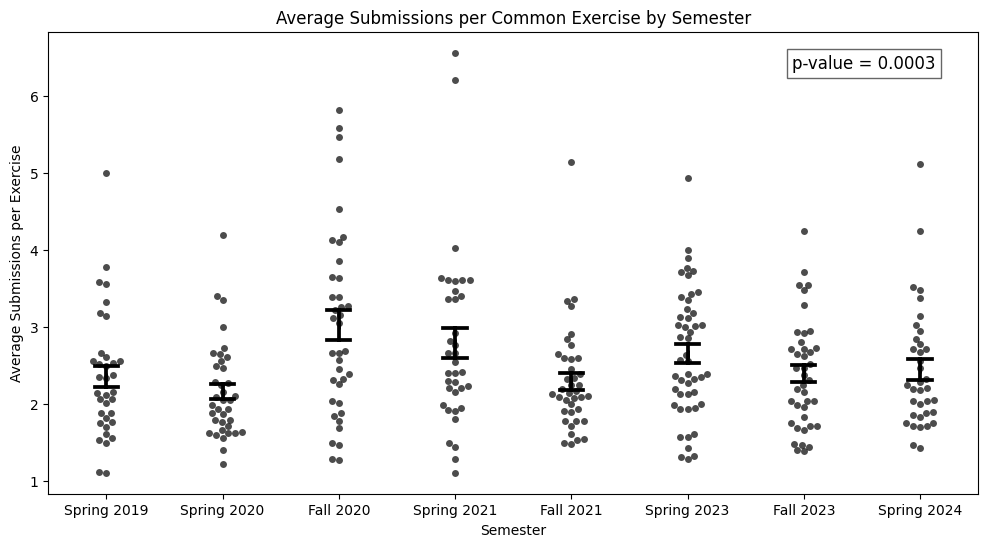

In [38]:
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

# Identify exercises that are common across all semesters and filter data
exercise_counts = data_cleaned.groupby('exercise_ssn')['Sem'].nunique()
common_exercises = exercise_counts[exercise_counts == data_cleaned['Sem'].nunique()].index
filtered_data = data_cleaned[(data_cleaned['exercise_ssn'].isin(common_exercises)) & (data_cleaned['user_id'].map(data_cleaned['user_id'].value_counts()) >= 100)]

# Calculate the average number of submissions per exercise for each engaged student in each semester
student_avg_submissions_common = filtered_data.groupby(['user_id', 'Sem'], as_index=False).apply(
    lambda x: pd.Series({'avg_submissions_per_exercise': x['submission_id'].count() / x['exercise_ssn'].nunique()}))

# Extract year and semester to sort chronologically
student_avg_submissions_common['Year'] = student_avg_submissions_common['Sem'].str.extract(r'(\d{4})').astype(int)
student_avg_submissions_common['Semester'] = student_avg_submissions_common['Sem'].str.contains("Spring").map({True: 0, False: 1})
student_avg_submissions_common = student_avg_submissions_common.sort_values(['Year', 'Semester']).drop(columns=['Year', 'Semester'])

# Plot
plt.figure(figsize=(12, 6))
sns.pointplot(data=student_avg_submissions_common, x='Sem', y='avg_submissions_per_exercise', errorbar='se', color='black', 
              capsize=0.2, join=False, markers='|', scale=1)
sns.swarmplot(data=student_avg_submissions_common, x='Sem', y='avg_submissions_per_exercise', color='black', alpha=0.7, size=5)
plt.title('Average Submissions per Common Exercise by Semester')
plt.xlabel('Semester')
plt.ylabel('Average Submissions per Exercise')

# ANOVA
anova_result = stats.f_oneway(
    *[student_avg_submissions_common[student_avg_submissions_common['Sem'] == sem]['avg_submissions_per_exercise'] 
      for sem in student_avg_submissions_common['Sem'].unique()]
)

# Display p value
p_value_text = f"p-value = {anova_result.pvalue:.4f}"
plt.text(0.80, 0.95, p_value_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))

plt.show()

Here, we are showing the distribution of average submissions per exercise per student in JUST the common exercises. Doesn't look so much different from the previous graph and it's hard to make any conslusions from something like this. Our central hypothesis before was that adding extra exercises in the later semesters should show a decreased average number of submissions per COMMON exercise from the previous semesters. In other words, students should struggle more (in general) with fewer exercises and thus have a higher average # of submissions whereas adding extra exercises in the later semesters would generally decrease the # of submissions in the same exercises that students previously should have struggled more with. Let's try to look at this in a different way. How about we compare each semester with itself and parse out the data into two groups- common exercises and unique exercises. In the earlier semesters, there will be fewer unique exercises but in the later semesters, there will be a greater #. This question aims to look at if adding a greater # of exercises increased or decreased the average # of submissions per exercise per student. Unsure if there will be a difference within each semester, but let's run the analysis.

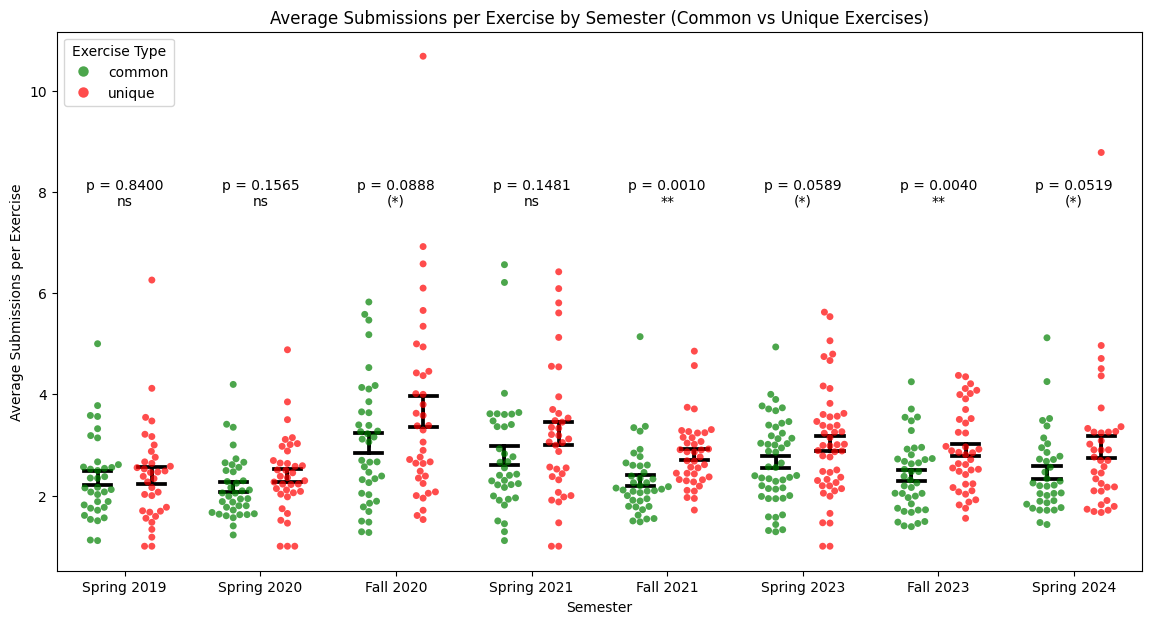

In [39]:
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Code more or less copied from before
exercise_counts = data_cleaned.groupby('exercise_ssn')['Sem'].nunique()
common_exercises = exercise_counts[exercise_counts == data_cleaned['Sem'].nunique()].index
data_cleaned['exercise_type'] = np.where(data_cleaned['exercise_ssn'].isin(common_exercises), 'common', 'unique')
filtered_data = data_cleaned[data_cleaned['user_id'].map(data_cleaned['user_id'].value_counts()) >= 100]

# Calculate average submissions per exercise per student, grouped by semester and exercise type
student_avg_submissions = filtered_data.groupby(['user_id', 'Sem', 'exercise_type'], as_index=False).apply(
    lambda x: pd.Series({'avg_submissions_per_exercise': x['submission_id'].count() / x['exercise_ssn'].nunique()}))
student_avg_submissions['Year'] = student_avg_submissions['Sem'].str.extract(r'(\d{4})').astype(int)
student_avg_submissions['Semester'] = student_avg_submissions['Sem'].str.contains("Spring").map({True: 0, False: 1})
student_avg_submissions = student_avg_submissions.sort_values(['Year', 'Semester']).drop(columns=['Year', 'Semester'])

# Plot
plt.figure(figsize=(14, 7))
sns.pointplot(data=student_avg_submissions, x='Sem', y='avg_submissions_per_exercise', hue='exercise_type',
              errorbar='se', palette=['black', 'black'], dodge=0.4, capsize=0.2, join=False, markers='|', scale=1, legend=False)
swarm = sns.swarmplot(data=student_avg_submissions, x='Sem', y='avg_submissions_per_exercise', hue='exercise_type',
                      dodge=True, palette=['green', 'red'], alpha=0.7, size=5, marker='o')
plt.title('Average Submissions per Exercise by Semester (Common vs Unique Exercises)')
plt.xlabel('Semester')
plt.ylabel('Average Submissions per Exercise')
handles, labels = swarm.get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='Exercise Type', loc='upper left', markerscale=1.5)

# Welch's t-test and show plot
unique_semesters = student_avg_submissions['Sem'].unique()
for i, sem in enumerate(unique_semesters):
    common_data = student_avg_submissions[(student_avg_submissions['Sem'] == sem) & (student_avg_submissions['exercise_type'] == 'common')]
    unique_data = student_avg_submissions[(student_avg_submissions['Sem'] == sem) & (student_avg_submissions['exercise_type'] == 'unique')]
    t_stat, p_value = stats.ttest_ind(common_data['avg_submissions_per_exercise'], unique_data['avg_submissions_per_exercise'], equal_var=False)
    if p_value < 0.0001:
        p_value_text = "****"
    elif p_value < 0.001:
        p_value_text = "***"
    elif p_value < 0.01:
        p_value_text = "**"
    elif p_value < 0.05:
        p_value_text = "*"
    elif p_value < 0.10:
        p_value_text = "(*)"
    else:
        p_value_text = "ns"
    plt.text(i, max(student_avg_submissions['avg_submissions_per_exercise']) - 3, f"p = {p_value:.4f}\n{p_value_text}", 
             ha='center', va='bottom', fontsize=10, color='black')

plt.show()

Wow! It seems that in almost every semester the "common" exercises seemed to have a fewer number of submissions than the "unique" exercises. Note: (*) refers to a "trending" result that approaches significance (0.05 < p < 0.10). How can this be interpreted? Are the "unique" exercises generally more difficult than the "common" exercises? Or are the "unique" exercises helping students get the "common" exercises correct sooner. It seems that the recent 4 semesters are either significant or approaching significance whereas the earliest 4 semesters are not significnat iwth just one semester approaching significance. The central question is still present- did adding additional exercises decrease the average submissions per students in the "common" exercises. In other words, are the additional exercises making the core "common" exercises easier? To answer this question, let's create two "binned" groups of the earliest 4 semesters and the most recent 4 semesters. First, we should identify if the # of exercises between these two groups are statistically significant. Next, let's run a similar analysis as above to show if there is a significant difference in average submission per exercise between the earliest 4 semesters with fewer exercises and the most recent 4 semesters with a greater # of exercises.

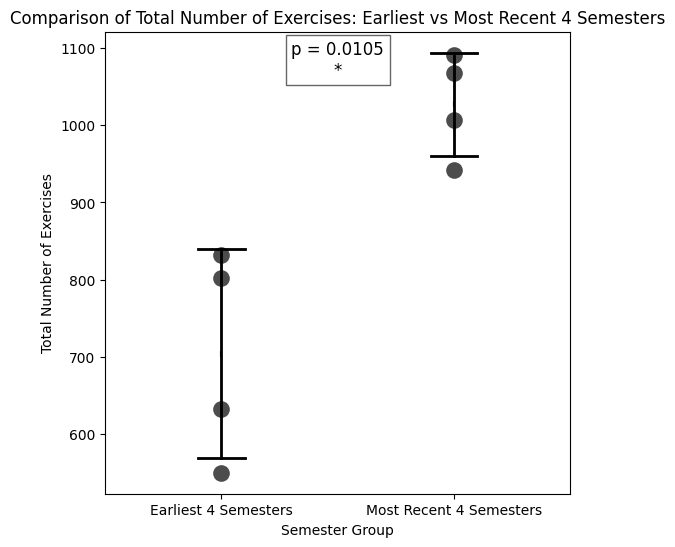

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import numpy as np

# Calculate the total number of exercises per semester
exercises_per_semester = data_cleaned.groupby('Sem')['exercise_ssn'].nunique().reset_index(name='total_exercises')

# Extract year and semester to sort chronologically and split into earliest and latest 4 semesters
exercises_per_semester['Year'] = exercises_per_semester['Sem'].str.extract(r'(\d{4})').astype(int)
exercises_per_semester['Semester'] = exercises_per_semester['Sem'].str.contains("Spring").map({True: 0, False: 1})
exercises_per_semester = exercises_per_semester.sort_values(['Year', 'Semester']).drop(columns=['Year', 'Semester'])
earliest_data = exercises_per_semester.iloc[:4]
recent_data = exercises_per_semester.iloc[-4:]

# Calculate mean and standard deviation
mean_earliest = earliest_data['total_exercises'].mean()
std_earliest = earliest_data['total_exercises'].std()
mean_recent = recent_data['total_exercises'].mean()
std_recent = recent_data['total_exercises'].std()

# t-test and combining data to plot
t_stat, p_value = stats.ttest_ind(earliest_data['total_exercises'], recent_data['total_exercises'], equal_var=False)
plot_data = pd.DataFrame({
    'Semester Group': ['Earliest 4 Semesters'] * len(earliest_data) + ['Most Recent 4 Semesters'] * len(recent_data),
    'Total Exercises': np.concatenate([earliest_data['total_exercises'], recent_data['total_exercises']])
})

# Plot
plt.figure(figsize=(6, 6))
sns.pointplot(data=plot_data, x='Semester Group', y='Total Exercises', capsize=0.2, join=False, 
              color='black', markers='|', scale=0.75, errorbar='sd')
sns.swarmplot(data=plot_data, x='Semester Group', y='Total Exercises', color='black', alpha=0.7, size=12)
y_min, y_max = plt.ylim()
p_value_text = f"p = {p_value:.4f}\n*"
plt.text(0.5, y_max * 0.95, 
         p_value_text, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.6))
plt.ylabel('Total Number of Exercises')
plt.title('Comparison of Total Number of Exercises: Earliest vs Most Recent 4 Semesters')
plt.show()


The earliest 4 and most recent 4 semesters have a significantly different # of total exercises. Let's now run a similar analysis as above to show if there is a significant difference in average submission per exercise between the earliest 4 semesters with fewer exercises and the most recent 4 semesters with a greater # of exercises.

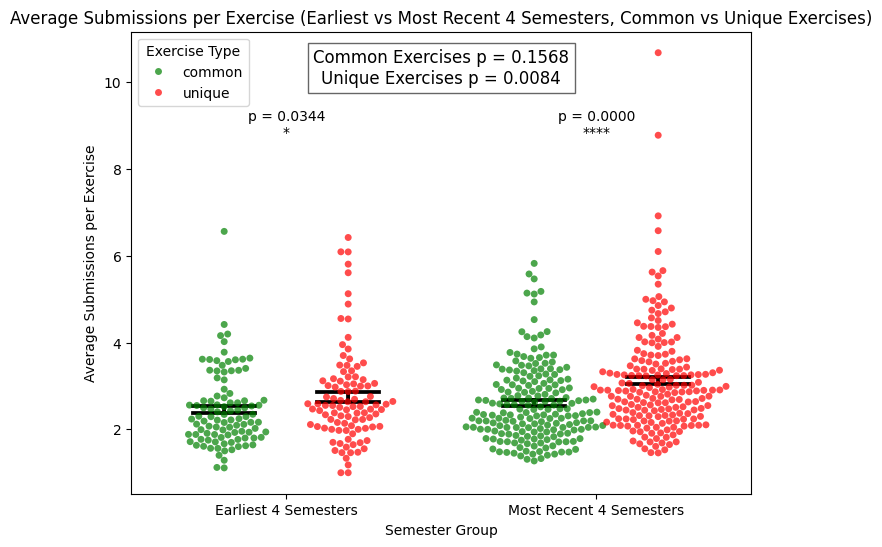

In [41]:
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Code more or less from before
exercise_counts = data_cleaned.groupby('exercise_ssn')['Sem'].nunique()
common_exercises = exercise_counts[exercise_counts == data_cleaned['Sem'].nunique()].index
data_cleaned['exercise_type'] = np.where(data_cleaned['exercise_ssn'].isin(common_exercises), 'common', 'unique')
filtered_data = data_cleaned[data_cleaned['user_id'].map(data_cleaned['user_id'].value_counts()) >= 100]

# Combine semesters into two groups (earliest 4 vs. recent 4)
filtered_data['Sem_Group'] = np.where(filtered_data['Sem'].isin(['Spring 2019', 'Fall 2019', 'Spring 2020', 'Spring 2021']), 
                                      'Earliest 4 Semesters', 'Most Recent 4 Semesters')

# Calculate average submissions per exercise per student for each group and exercise type
student_avg_submissions = filtered_data.groupby(['user_id', 'Sem_Group', 'exercise_type'], as_index=False).apply(
    lambda x: pd.Series({'avg_submissions_per_exercise': x['submission_id'].count() / x['exercise_ssn'].nunique()}))

# Plot
plt.figure(figsize=(8, 6))
sns.pointplot(data=student_avg_submissions, x='Sem_Group', y='avg_submissions_per_exercise', hue='exercise_type',
              errorbar='se', palette=['black', 'black'], dodge=0.4, capsize=0.2, join=False, markers='|', scale=1, legend=False)
swarm = sns.swarmplot(data=student_avg_submissions, x='Sem_Group', y='avg_submissions_per_exercise', hue='exercise_type',
                      dodge=True, palette=['green', 'red'], alpha=0.7, size=5, marker='o')
plt.title('Average Submissions per Exercise (Earliest vs Most Recent 4 Semesters, Common vs Unique Exercises)')
plt.xlabel('Semester Group')
plt.ylabel('Average Submissions per Exercise')
handles, labels = swarm.get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='Exercise Type', loc='upper left')

# Welch's t-tests
for i, sem_group in enumerate(['Earliest 4 Semesters', 'Most Recent 4 Semesters']):
    common_data = student_avg_submissions[(student_avg_submissions['Sem_Group'] == sem_group) & (student_avg_submissions['exercise_type'] == 'common')]
    unique_data = student_avg_submissions[(student_avg_submissions['Sem_Group'] == sem_group) & (student_avg_submissions['exercise_type'] == 'unique')]
    t_stat, p_value = stats.ttest_ind(common_data['avg_submissions_per_exercise'], unique_data['avg_submissions_per_exercise'], equal_var=False)
    p_value_text = "****" if p_value < 0.0001 else "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "(*)" if p_value < 0.1 else "ns"
    plt.text(i, max(student_avg_submissions['avg_submissions_per_exercise']) - 2, 
             f"p = {p_value:.4f}\n{p_value_text}", ha='center', va='bottom', fontsize=10, color='black')

earliest_common = student_avg_submissions[(student_avg_submissions['Sem_Group'] == 'Earliest 4 Semesters') & (student_avg_submissions['exercise_type'] == 'common')]
recent_common = student_avg_submissions[(student_avg_submissions['Sem_Group'] == 'Most Recent 4 Semesters') & (student_avg_submissions['exercise_type'] == 'common')]
earliest_unique = student_avg_submissions[(student_avg_submissions['Sem_Group'] == 'Earliest 4 Semesters') & (student_avg_submissions['exercise_type'] == 'unique')]
recent_unique = student_avg_submissions[(student_avg_submissions['Sem_Group'] == 'Most Recent 4 Semesters') & (student_avg_submissions['exercise_type'] == 'unique')]

t_stat_common, p_value_common = stats.ttest_ind(earliest_common['avg_submissions_per_exercise'], recent_common['avg_submissions_per_exercise'], equal_var=False)
t_stat_unique, p_value_unique = stats.ttest_ind(earliest_unique['avg_submissions_per_exercise'], recent_unique['avg_submissions_per_exercise'], equal_var=False)
overall_p_text = f"Common Exercises p = {p_value_common:.4f}\nUnique Exercises p = {p_value_unique:.4f}"

plt.text(0.5, max(student_avg_submissions['avg_submissions_per_exercise']) -0.7, 
         overall_p_text, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.6))
plt.show()

Interesting data! Here, I am showing that within the two groups of early semesters vs recent semesters it seems that students had more submissions on the "unique" exercises than the exercises that were "common" throughout all of the courses. This could be interpreted as these "unique" exercises simply being more difficult. However, interestingly, the addition of the unique exercises did NOT significantly change the number of submissions per exercise in the "common" exercises. Assuming that the course was built in a way that the "common" exercises very early on were designed to allow students to gain mastery over the course, this analysis MAY suggest that (put simply) MORE EXERCISES does not necessarily mean BETTER PERFORMANCE. Of course, looking at average # of submissions per exercise is not the best measure of performance, but it SHOULD be the case that additional exercises added should make other exercises in a particular topic easier. But perhaps it may be the case that these additional exercises were added AFTER the exercises that are "common" to build on top of that basis, thus, causing no change in avg submissions per exercise. However, it also seems that students in the most recent 4 semesters had a signficiantly greater submission rate per UNIQUE exercise (p = 0.0084). This MAY suggest that these new exercises that are being added are more difficult. OVERALL, the conclusions here are somewhat inconclusive. Let's now move onto identifying consistently challenging exercises, identified by the average submission per student for that exercise, within the "common" exercise group. 

In [42]:
import pandas as pd

# Filter data to include only "common" exercises
common_exercises_data = data_cleaned[data_cleaned['exercise_type'] == 'common']

# Calculate the average number of submissions per exercise per student for each common exercise
challenging_exercises = common_exercises_data.groupby('exercise_ssn').apply(
    lambda x: x['submission_id'].count() / x['user_id'].nunique()).reset_index(name='avg_submissions_per_student')

# Sort exercises by the average number of submissions per student in descending order and select the top 25
top_25_challenging_exercises = challenging_exercises.sort_values(by='avg_submissions_per_student', ascending=False).head(25)

# Display the results
top_25_challenging_exercises.reset_index(drop=True, inplace=True)
top_25_challenging_exercises

,exercise_ssn,avg_submissions_per_student
0,317682-00495,16.027933
1,317682-00473,12.351598
2,317682-00490,10.464865
3,00001-20882,10.149733
4,317682-00488,10.122093
5,00001-20884,9.860825
6,00001-20934,9.529412
7,317682-00480,8.429577
8,317682-00496,7.895161
9,00001-20845,7.786164


Now, lets assign topics to each of these exercises to better contextualize the topics that students are struggling with. This will be exported as a csv, topics will be manually added, and imported back.

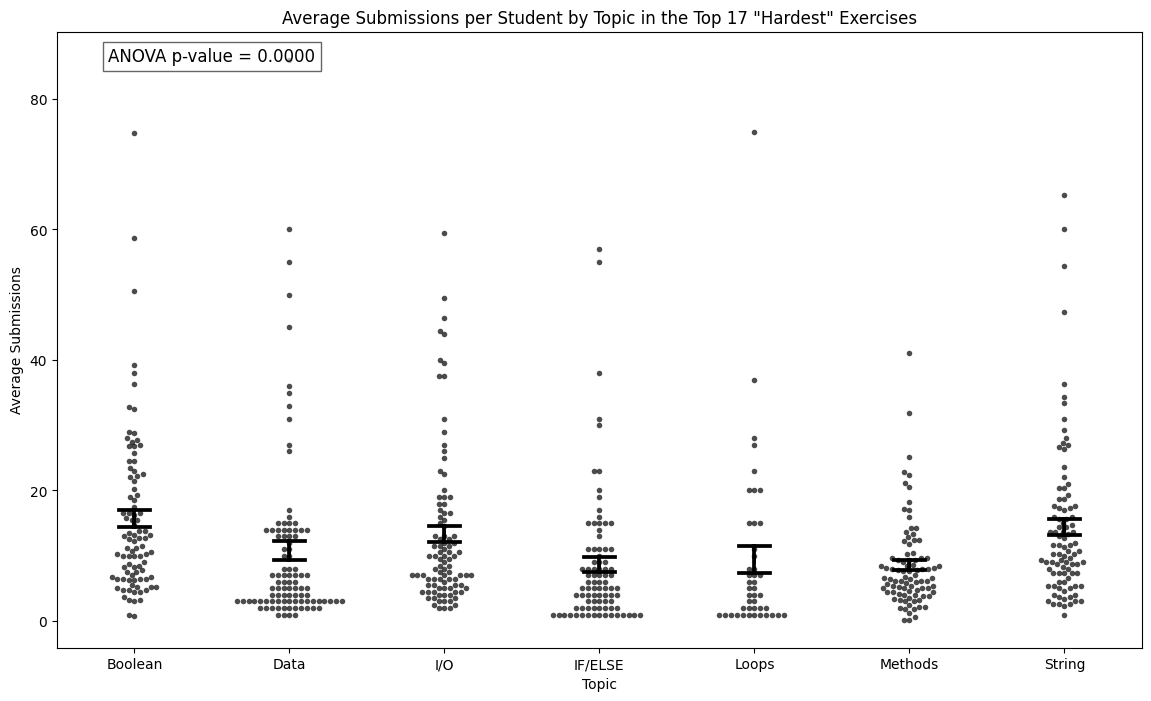

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Load datasets
main_data_path = '~/cisc5001/Submission_Data_Raw.csv'  
top_25_path = '~/cisc5001/top17challenging.csv'
main_data = pd.read_csv(main_data_path)
top_25_data = pd.read_csv(top_25_path)

# Merge datasets and filter for "engaged" students (>=100 submissions)
merged_data = pd.merge(main_data, top_25_data[['exercise_ssn', 'Topic']], on='exercise_ssn', how='inner')
engaged_students = merged_data.groupby('user_id')['submission_id'].count() >= 100
merged_data = merged_data[merged_data['user_id'].isin(engaged_students[engaged_students].index)]
student_topic_data = merged_data.groupby(['user_id', 'Topic'], as_index=False)['submission_id'].count()

# Calculate average submissions per student per exercise within each topic
topic_counts = top_25_data['Topic'].value_counts().to_dict()
student_topic_data['standardized_submissions'] = student_topic_data.apply(
    lambda row: row['submission_id'] / topic_counts[row['Topic']], axis=1
)

# ANOVA
anova_data = [group['standardized_submissions'].values for name, group in student_topic_data.groupby('Topic')]
f_stat, p_value = stats.f_oneway(*anova_data)

# Plot
plt.figure(figsize=(14, 8))
sns.pointplot(data=student_topic_data, x='Topic', y='standardized_submissions', errorbar='se', color='black', capsize=0.2, join=False, markers='|', scale=1)
sns.swarmplot(data=student_topic_data, x='Topic', y='standardized_submissions', color='black', alpha=0.7, size=4)
plt.title('Average Submissions per Student by Topic in the Top 17 "Hardest" Exercises')
plt.xlabel('Topic')
plt.ylabel('Average Submissions')
y_min, y_max = plt.ylim()
p_value_text = f"ANOVA p-value = {p_value:.4f}"
plt.text(0.5, y_max * 0.95, p_value_text, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.6))
plt.show()

Within the top 17 "most challenging" exercises, it seems that some topics had a greater # of average submissions. These topics were broadly assigned and it seems that students likely struggle with booleans and strings the most, although keep in mind these specific topics all showed up in the top 25 highest submitted exercises. Next, I will run a deeper analysis by assigning broad topics to more of the "common" exercises and seeing broadly what students struggled with the most outside of the top 25 that was ran above.

After making a subset of common exercises to account for differences between courses, what % of students (who had engagement with the course) simply gave up on an exercise and never returned to get it correct? Which exercises were those? Do students who give up on an exercise generally tend to submit more? 

In [44]:
import pandas as pd

# Load the dataset
file_path = '~/cisc5001/Common_Submissions.csv'
data = pd.read_csv(file_path)

# Group by user_id and exercise_ssn to determine if a student ever answered correctly
grouped = data.groupby(['user_id', 'exercise_ssn'])['is_correct'].any().reset_index(name='ever_correct')

# Calculate the percentage of students who never answered correctly for each exercise
exercise_stats = grouped.groupby('exercise_ssn').apply(
    lambda x: 100 * (1 - x['ever_correct'].mean())  # Percentage of students who never answered correctly
).reset_index(name='percent_never_correct')

# Sort by the highest percentage of students who never answered correctly
top_25_hardest_exercises = exercise_stats.sort_values(by='percent_never_correct', ascending=False).head(25)

# Display the results
print(top_25_hardest_exercises)

     exercise_ssn  percent_never_correct
320  317682-00496              19.354839
319  317682-00495              18.435754
300  317682-00473              17.808219
196   00001-20934              14.973262
167   00001-20882              14.438503
321  317682-00497              13.793103
198   00001-20936              13.636364
313  317682-00488              13.372093
197   00001-20935              12.804878
131   00001-20787              12.056738
306  317682-00480              11.267606
195   00001-20933              10.909091
259   00001-21217               9.638554
316  317682-00491               8.571429
299  317682-00363               8.502024
307  317682-00481               8.148148
315  317682-00490               8.108108
301  317682-00474               8.056872
199   00001-20937               7.692308
314  317682-00489               7.586207
304  317682-00477               6.842105
302  317682-00475               6.403941
153   00001-20845               6.289308
169   00001-2088

In [45]:
challenging_exercises = pd.read_csv('~/cisc5001/top_25_challenging_common_exercises.csv') 

common_exercises = pd.merge(
    top_25_hardest_exercises,
    challenging_exercises[['exercise_ssn', 'avg_submissions_per_student']],
    on='exercise_ssn'
)

print("Common exercises in both top 25 lists:")
print(common_exercises)
common_exercises.to_csv('top17challenging.csv', index=False)

Common exercises in both top 25 lists:
    exercise_ssn  percent_never_correct  avg_submissions_per_student
0   317682-00496              19.354839                     7.895161
1   317682-00495              18.435754                    16.027933
2   317682-00473              17.808219                    12.351598
3    00001-20934              14.973262                     9.529412
4    00001-20882              14.438503                    10.149733
5   317682-00488              13.372093                    10.122093
6   317682-00480              11.267606                     8.429577
7    00001-21217               9.638554                     6.879518
8   317682-00491               8.571429                     5.664286
9   317682-00363               8.502024                     7.712551
10  317682-00481               8.148148                     5.874074
11  317682-00490               8.108108                    10.464865
12   00001-20937               7.692308                     6.69

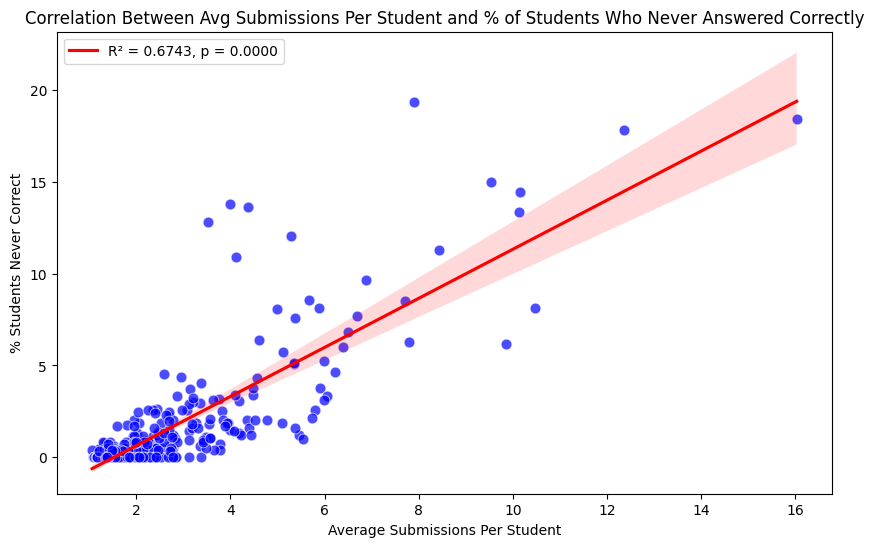

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Load dataset
common_submissions = pd.read_csv('~/cisc5001/Common_Submissions.csv')

# Calculate the % of students who never answered correctly for each exercise
never_correct = common_submissions.groupby(['exercise_ssn', 'user_id'])['is_correct'].any().groupby('exercise_ssn').apply(lambda x: 100 * (~x).mean()).reset_index(name='Percent Never Correct')

# Calculate the average submissions per student for each exercise
avg_submissions = common_submissions.groupby(['exercise_ssn', 'user_id'])['is_correct'].count().groupby('exercise_ssn').mean().reset_index(name='Avg Submissions Per Student')

# Merge
exercise_stats = pd.merge(never_correct, avg_submissions, on='exercise_ssn')

# Plot scatter plot with regression line
slope, intercept, r_value, p_value, std_err = linregress(exercise_stats['Avg Submissions Per Student'], exercise_stats['Percent Never Correct'])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=exercise_stats, x='Avg Submissions Per Student', y='Percent Never Correct', color='blue', s=60, alpha=0.7)
sns.regplot(data = exercise_stats, x= 'Avg Submissions Per Student', y = 'Percent Never Correct',  color='red', scatter =False, label=f'R² = {r_value**2:.4f}, p = {p_value:.4f}')
plt.title('Correlation Between Avg Submissions Per Student and % of Students Who Never Answered Correctly')
plt.xlabel('Average Submissions Per Student')
plt.ylabel('% Students Never Correct')
plt.legend()
plt.show()

How many attempts did it take on average for a student to give up on an exercise?

In [47]:
# Filter for student-exercise pairs where the student never answered correctly
never_correct_data = common_submissions.groupby(['user_id', 'exercise_ssn'])['is_correct'].any().reset_index()
never_correct_data = never_correct_data[never_correct_data['is_correct'] == False]

# Count total submissions for each student-exercise pair
attempts_per_exercise = common_submissions[common_submissions.set_index(['user_id', 'exercise_ssn']).index.isin(never_correct_data.set_index(['user_id', 'exercise_ssn']).index)]
attempts_per_exercise = attempts_per_exercise.groupby(['user_id', 'exercise_ssn']).size().reset_index(name='num_attempts')

# Calculate the average number of attempts before giving up
avg_attempts_before_give_up = attempts_per_exercise['num_attempts'].mean()
print(avg_attempts_before_give_up)

7.765848670756646
